<a href="https://colab.research.google.com/github/surya211099/DetectingPhishingEmail/blob/main/MLP%2BLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6324 - loss: 0.6455 - val_accuracy: 0.7079 - val_loss: 0.5848
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6996 - loss: 0.5844 - val_accuracy: 0.7264 - val_loss: 0.5474
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7362 - loss: 0.5341 - val_accuracy: 0.8091 - val_loss: 0.4567
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7882 - loss: 0.4689 - val_accuracy: 0.8167 - val_loss: 0.4156
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8061 - loss: 0.4384 - val_accuracy: 0.8268 - val_loss: 0.3968
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8147 - loss: 0.4223 - val_accuracy: 0.8355 - val_loss: 0.3943
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8224 - loss: 0.4121 - val_accuracy: 0.8385 - val_loss: 0.3744
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8274 - loss: 0.4009 - val_accuracy: 0.8374 - val_

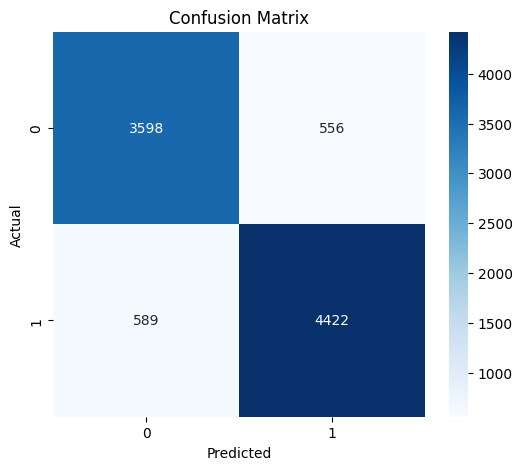

In [2]:
#MLP+LR
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 6. Get LR probabilities as new feature
train_lr_prob = lr_model.predict_proba(X_train)[:,1].reshape(-1,1)
test_lr_prob = lr_model.predict_proba(X_test)[:,1].reshape(-1,1)

# 7. Append LR probability to original features
X_train_hybrid = np.hstack([X_train, train_lr_prob])
X_test_hybrid = np.hstack([X_test, test_lr_prob])

# 8. Build MLP classifier
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(X_train_hybrid.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

mlp.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train MLP
mlp.fit(X_train_hybrid, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.1,
        shuffle=True,
        callbacks=[early_stop],
        verbose=1)

# 10. Predictions
y_pred_prob = mlp.predict(X_test_hybrid).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# 11. Evaluation metrics
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Log Loss:", ll)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)

# 12. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


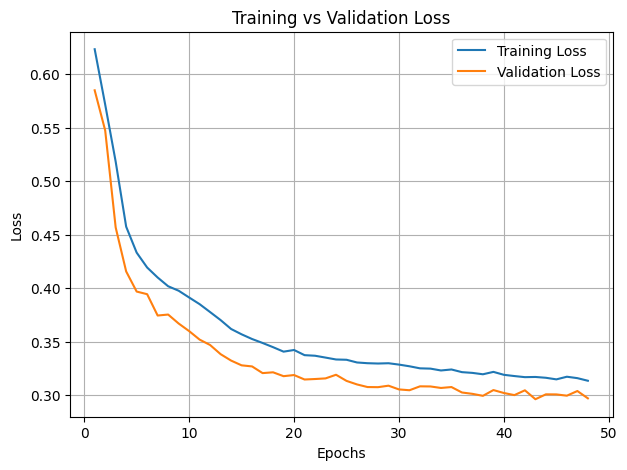

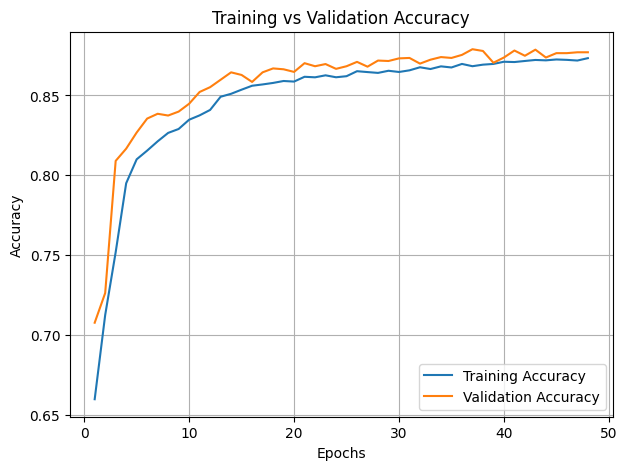

In [3]:
# === TRAIN vs VALIDATION CURVES ===

# history object returned by model.fit()
history_dict = mlp.history.history

# Extract metrics
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6334 - loss: 0.6417 - val_accuracy: 0.7038 - val_loss: 0.5892
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7078 - loss: 0.5848 - val_accuracy: 0.7220 - val_loss: 0.5646
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7269 - loss: 0.5606 - val_accuracy: 0.7289 - val_loss: 0.5491
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7309 - loss: 0.5474 - val_accuracy: 0.7387 - val_loss: 0.5163
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7470 - loss: 0.5201 - val_accuracy: 0.7681 - val_loss: 0.4721
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7748 - loss: 0.4870 - val_accuracy: 0.8186 - val_loss: 0.4263
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8021 - loss: 0.4433 - val_accuracy: 0.8306 - val_loss: 0.3952
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8158 - loss: 0.4261 - val_accuracy: 0.8366 - val_

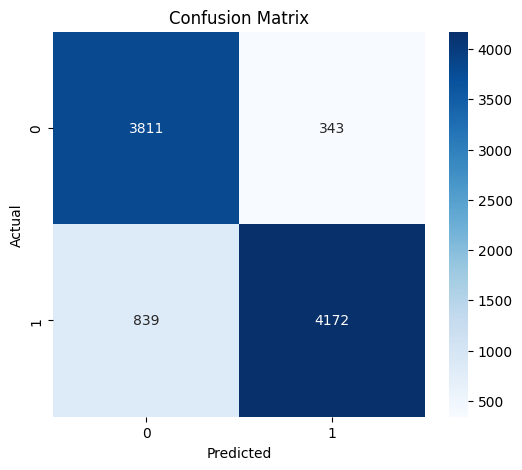

In [4]:
#MLP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, log_loss, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Prepare features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Build MLP classifier
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # binary classification

mlp.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. Train MLP
mlp.fit(X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.1,
        shuffle=True,
        callbacks=[early_stop],
        verbose=1)

# 7. Predictions
y_pred_prob = mlp.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# 8. Evaluation metrics
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Log Loss:", ll)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)

# 9. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


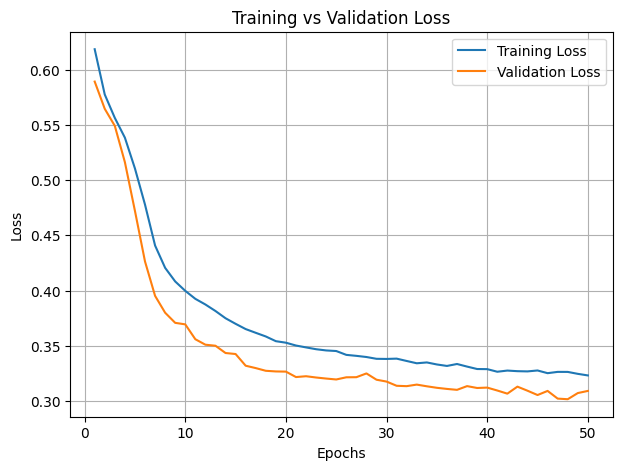

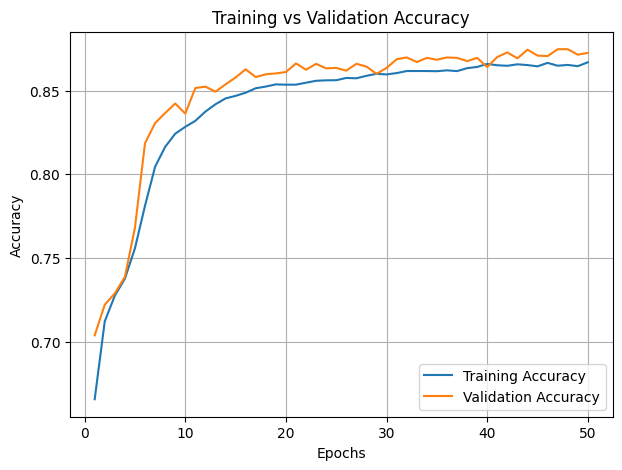

In [5]:
# === TRAIN vs VALIDATION CURVES ===

# Get training history
history = mlp.history.history

epochs = range(1, len(history['loss']) + 1)

# ---- Loss Curve ----
plt.figure(figsize=(7,5))
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---- Accuracy Curve ----
plt.figure(figsize=(7,5))
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.6002182214948173
Log Loss: 0.6583147330422574
Precision: 0.6073991388933184
Recall: 0.76012771901816
F1 Score: 0.6752348874313066

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.41      0.48      4154
           1       0.61      0.76      0.68      5011

    accuracy                           0.60      9165
   macro avg       0.60      0.58      0.58      9165
weighted avg       0.60      0.60      0.59      9165


Confusion Matrix:
 [[1692 2462]
 [1202 3809]]


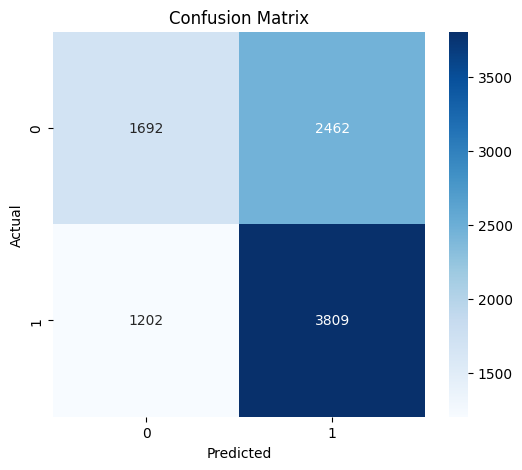

In [6]:
#LR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, precision_score,
                             recall_score, f1_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dessertation/phishing_numeric_dataset.csv')  # replace with your CSV path

# 2. Prepare features and label
features = ['sender', 'receiver', 'subject', 'body', 'urls', 'timestamp']  # numeric
X = df[features].values
y = df['label'].values  # 0=legit, 1=phishing

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 6. Predictions
y_pred_prob = lr_model.predict_proba(X_test)[:,1]
y_pred = lr_model.predict(X_test)

# 7. Evaluation metrics
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Log Loss:", ll)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)

# 8. Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


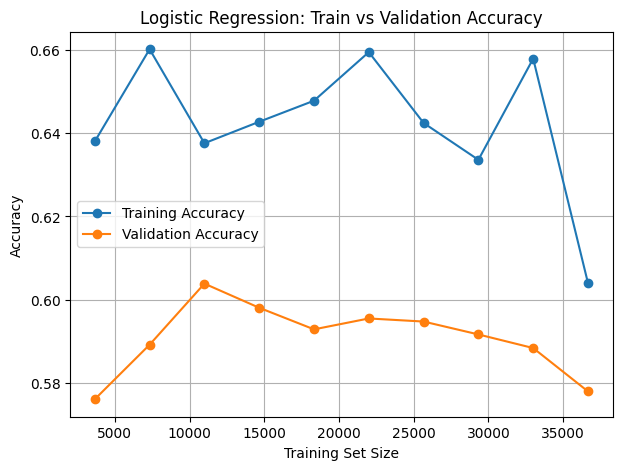

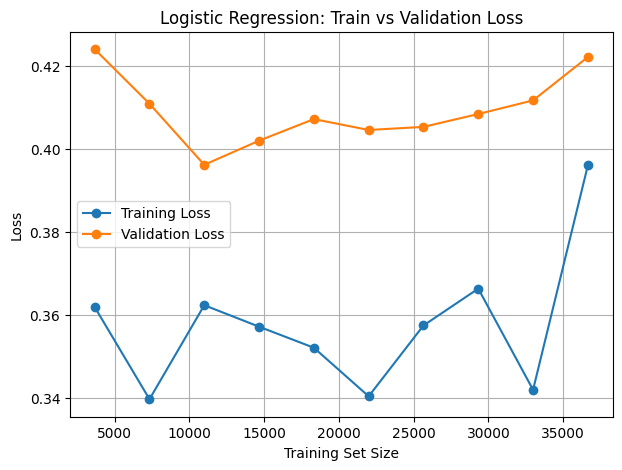

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    lr_model,
    X_scaled,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Mean scores
train_acc_mean = np.mean(train_scores, axis=1)
val_acc_mean = np.mean(val_scores, axis=1)

# Convert accuracy to loss
train_loss = 1 - train_acc_mean
val_loss = 1 - val_acc_mean

# ---- Accuracy Curve ----
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_acc_mean, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_acc_mean, marker='o', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- Loss Curve ----
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_loss, marker='o', label='Training Loss')
plt.plot(train_sizes, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Loss')
plt.title('Logistic Regression: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
